## Problem description

In [1]:
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from IPython.display import display

## A variety of helper functions from RMG-database's fitGAVSFromThermoLibrary.ipynb

In [2]:
def addThermoData(thermoData1, thermoData2):
    """
    Add the thermodynamic data `thermoData2` to the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] += thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si += thermoData2.H298.value_si
    thermoData1.S298.value_si += thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def removeThermoData(thermoData1, thermoData2):
    """
    Remove the thermodynamic data `thermoData2` from the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] -= thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si -= thermoData2.H298.value_si
    thermoData1.S298.value_si -= thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def averageThermoData(thermoDataset=[]):
    """
    Average a list of thermoData values together.
    Sets uncertainty values to be the approximately the 95% confidence interval, equivalent to
    2 standard deviations calculated using the sample standard variance:
    
    Uncertainty = 2s
    s = sqrt( sum(abs(x - x.mean())^2) / N - 1) where N is the number of values averaged
    
    Note that uncertainties are only computed when number of values is greater than 1.
    """
    
    numValues = len(thermoDataset)
        
    if numValues == 0:
        raise Exception('No thermo data values were inputted to be averaged.')
    else:
        print 'Averaging thermo data over {0} value(s).'.format(numValues)
        
        if numValues == 1:
            return copy.deepcopy(thermoDataset[0])
        
        else:
            averagedThermoData = copy.deepcopy(thermoDataset[0])
            for thermoData in thermoDataset[1:]:
                averagedThermoData = addThermoData(averagedThermoData, thermoData)


            for i in range(averagedThermoData.Tdata.value_si.shape[0]):
                averagedThermoData.Cpdata.value_si[i] /= numValues
                #print averagedThermoData.Cpdata.uncertainty
                cpData = [thermoData.Cpdata.value_si[i] for thermoData in thermoDataset]
                averagedThermoData.Cpdata.uncertainty[i] = 2*numpy.std(cpData, ddof=1)

            HData = [thermoData.H298.value_si for thermoData in thermoDataset]
            averagedThermoData.H298.value_si /= numValues
            averagedThermoData.H298.uncertainty_si = 2*numpy.std(HData, ddof=1)

            SData = [thermoData.S298.value_si for thermoData in thermoDataset]
            averagedThermoData.S298.value_si /= numValues
            averagedThermoData.S298.uncertainty_si = 2*numpy.std(SData, ddof=1)
            return averagedThermoData
        
def extractPolycyclicGroups(molecule):
    """
    Extract polycyclic functional groups from a real molecule
    """
    struct = molecule.copy(deep=True)
    # Saturate the structure if it is a radical
    if struct.isRadical():
        struct.saturate()
    struct.deleteHydrogens()
    
    polyRings = struct.getPolycyclicRings()
    groups = [convertCycleToGroup(ring) for ring in polyRings]
    
    return groups
                
def convertCycleToGroup(cycle):
    """
    This function converts a list of atoms in a cycle to a functional Group object
    """
    from rmgpy.molecule.group import GroupAtom, GroupBond, Group
    
    # Create GroupAtom object for each atom in the cycle, label the first one in the cycle with a *
    groupAtoms = {}
    bonds = []
    for atom in cycle:
        groupAtoms[atom] = GroupAtom(atomType=[atom.atomType],
                                     radicalElectrons=[0],
                                     label='*' if cycle.index(atom)==0 else '')
                
    group = Group(atoms=groupAtoms.values())            
    
    # Create GroupBond for each bond between atoms in the cycle, but not outside of the cycle
    for atom in cycle:
        for bondedAtom, bond in atom.edges.iteritems():
            if bondedAtom in cycle:
                # create a group bond with the same bond order as in the original molecule,
                # if it hasn't already been created
                if not group.hasBond(groupAtoms[atom],groupAtoms[bondedAtom]):
                    group.addBond(GroupBond(groupAtoms[atom],groupAtoms[bondedAtom],order=[bond.order]))
            else:
                pass
        
    group.update()
    
    return group

def returnPolycyclicGroupStrings(thermoComment):
    """
    Takes a string of comments from group additivity estimation, and extracts the polycyclic group strings out of them
    """
    tokens = thermoComment.split()
    polycyclicGroups = []
    for token in tokens:
        if 'polycyclic' in token:
            splitTokens = re.split("\(|\)",token)
            assert len(splitTokens) == 3
            groupLabel = splitTokens[1]
            polycyclicGroups.append(groupLabel)
    return polycyclicGroups

def displayThermo(thermoData):
    print 'H298 = {0} kcal/mol'.format(thermoData.H298.value_si/4184)
    print 'S298 = {0} cal/mol*K'.format(thermoData.S298.value_si/4.184)
def compareThermoData(thermoData1, thermoData2):
    delH = thermoData1.H298.value_si - thermoData2.H298.value_si
    print 'Difference in H298 = {0} kcal/mol'.format(delH/4184)
    delS = thermoData1.S298.value_si - thermoData2.S298.value_si
    print 'Difference S298 = {0} cal/mol*K'.format(delS/4.184)
    #Tdata = [300,500,1000,2000]
    #for T in Tdata:
    #    delCp = thermoData1.getHeatCapacity(T) - thermoData2.getHeatCapacity(T)
    #    print 'Difference in Cp at {0} = {1} cal/mol*K'.format(T, delCp/4.184)

In [3]:
# Load the thermo database
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries='none',\
             kineticsFamilies='none', kineticsDepositories='none', reactionLibraries = [])

thermoDatabase = database.thermo

In [4]:
spec1 = Species().fromSMILES('C1CC1')
spec1.generateResonanceIsomers()
spec1_thermo = thermoDatabase.getThermoDataFromGroups(spec1)
displayThermo(spec1_thermo)

H298 = 12.74 kcal/mol
S298 = 56.7082039346 cal/mol*K


## Species 1
A species with two rings, one aromatic, one not.  It should distinct ring corrections for each ring.

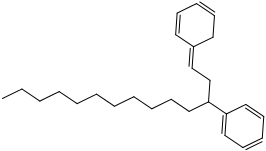

In [5]:
spec1 = Species().fromSMILES('CCCCCCCCCCCC(CC=C1C=CC=CC1)c1ccccc1')
spec1.generateResonanceIsomers()
spec1

In [6]:
spec1_thermo = thermoDatabase.estimateThermoViaGroupAdditivity(spec1.molecule[1])
displayThermo(spec1_thermo)
print ''
print spec1_thermo.comment

H298 = -5.9 kcal/mol
S298 = 229.011830518 cal/mol*K

Thermo group additivity estimation: group(Cs-CbCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cb-Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + ring(Benzene) + ring(13cyclohexadiene5methylene)


we only need one ring correction (`ring(13cyclohexadiene5methylene)`), but RMG gives two. This is caused by the code block below:
```python
def computeGroupAdditivityThermo(self, molecule):
....
    rings = molecule.getSmallestSetOfSmallestRings()
    for ring in rings:
        # Make a temporary structure containing only the atoms in the ring
        # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
        try:
            self.__addGroupThermoData(thermoData, self.groups['ring'], molecule, {})
        except KeyError:
            logging.error("Couldn't find in ring database:")
            logging.error(ring)
            logging.error(ring.toAdjacencyList())
            raise
```

### After the new commit

In [7]:
spec1_thermo = thermoDatabase.estimateThermoViaGroupAdditivity(spec1.molecule[1])
displayThermo(spec1_thermo)
print ''
print spec1_thermo.comment

H298 = -5.9 kcal/mol
S298 = 229.011830518 cal/mol*K

Thermo group additivity estimation: group(Cs-CbCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cb-Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + ring(Benzene) + ring(13cyclohexadiene5methylene)


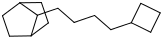

H298 = -19.49 kcal/mol
S298 = 138.61 cal/mol*K

Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + ring(Cyclobutane) + polycyclic(norbornane)


In [8]:
# Species 2
# Test a species with a polycyclic and a cyclic ring inside it.
spec2 = Species().fromSMILES('C(CCC1C2CCC1CC2)CC1CCC1')
display(spec2)
spec2.generateResonanceIsomers()
spec2_thermo = thermoDatabase.getThermoDataFromGroups(spec2)
displayThermo(spec2_thermo)
print ''
print spec2_thermo.comment

[Molecule(SMILES="C1=CC=CC=C1"), Molecule(SMILES="c1ccccc1")]


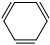

H298 = 40.76 kcal/mol
S298 = 56.4077 cal/mol*K
Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + ring(Cyclohexane)


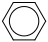

H298 = 19.8 kcal/mol
S298 = 69.18 cal/mol*K
Thermo group additivity estimation: group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + ring(Benzene)
H298 = 19.8 kcal/mol
S298 = 64.2419773513 cal/mol*K
final
[Molecule(SMILES="c1ccccc1"), Molecule(SMILES="C1=CC=CC=C1")]

Thermo group additivity estimation: group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + ring(Benzene)


In [9]:
# Species 3
# Benzene
spec3 = Species().fromSMILES('c1ccccc1')
spec3.generateResonanceIsomers()
print spec3.molecule
for molecule in spec3.molecule:
    display(molecule)
    thermo = thermoDatabase.computeGroupAdditivityThermo(molecule)
    displayThermo(thermo)
    print thermo.comment
spec3_thermo = thermoDatabase.getThermoDataFromGroups(spec3)
displayThermo(spec3_thermo)
print 'final'
print spec3.molecule
print ''
print spec3_thermo.comment

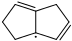

H298 = 79.627 kcal/mol
S298 = 84.48 cal/mol*K
Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(C12CCC=C1CC=C2) + radical(Tertalkyl)


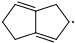

H298 = 46.097 kcal/mol
S298 = 22.13 cal/mol*K
Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)


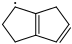

H298 = 46.047 kcal/mol
S298 = 22.46 cal/mol*K
Thermo group additivity estimation: group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)
H298 = 79.627 kcal/mol
S298 = 84.48 cal/mol*K
final
[Molecule(SMILES="C1=C[C]2CCC=C2C1"), Molecule(SMILES="[CH]1CCC2C=CCC=21"), Molecule(SMILES="[CH]1C=C2CCC=C2C1")]

Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(C12CCC=C1CC=C2) + radical(Tertalkyl)


In [24]:
spec = Species().fromSMILES('C1=C[C]2CCC=C2C1')
spec.generateResonanceIsomers()
for molecule in spec.molecule:
    display(molecule)
    thermo = thermoDatabase.estimateRadicalThermoViaHBI(molecule, thermoDatabase.computeGroupAdditivityThermo)
    displayThermo(thermo)
    print thermo.comment
spec_thermo = thermoDatabase.getThermoDataFromGroups(spec)
displayThermo(spec_thermo)
print 'final'
print spec.molecule
print ''
print spec_thermo.comment

In [10]:
import numpy
array = numpy.array([3.0,2.0])
b = array.argsort()
print b
print b[::-1]

[1 0]
[0 1]


## Test the groups within the ring corrections

In [11]:
ringGroupEntries = thermoDatabase.groups['ring'].entries.values()

In [12]:
# Clear the labeled atoms and run isomorphism check for duplicates

for i in range(len(ringGroupEntries)):
    for j in range(i+1,len(ringGroupEntries)):
        if thermoDatabase.groups['ring'].matchNodeToNode(ringGroupEntries[i],ringGroupEntries[j]):
            print 'Group {0} is isomorphic to group {1}'.format(ringGroupEntries[i].label,ringGroupEntries[j].label)

ringGroupEntries[4].item.getSmallestSetOfSmallestRings()

[[<GroupAtom ['Cs']>, <GroupAtom ['Cs']>, <GroupAtom ['Cs']>]]

In [13]:
# for entry in ringGroupEntries:
#     group = entry.item
#     monorings, polyrings = group.getDisparateRings()
#     # There should be no polyrings
#     assert len(polyrings) == 0
#     # There should be 1 or 0 monorings present
#     assert len(monorings) <= 1
    
#     if monorings:
#         entry.item.clearLabeledAtoms()
#         for atom in monorings[0]:
#             atom.label = '*'
#     print group.toAdjacencyList()
#     print group.getLabeledAtoms()
# thermoDatabase.groups['ring'].save('newRing.py')